In [6]:
import matplotlib.pyplot as plt
import numpy as onp
import jax.numpy as jnp
from jax import random
from jax.scipy.stats import norm

from jax_sgmc import data, potential, scheduler, adaption, integrator, solver, io
from jax_sgmc.data.numpy_loader import NumpyDataLoader

# Setup Solver

## Construct Solver

The Solver is applied to the problem in quickstart.


### Setup Reference Data Loading

The reference data is passed to the solver via two components, the data loader
and the host callback wrapper.

The host callback wrappers load the data into the jit-compiled programs via
``host_callback.call()``. To balance the memory usage and the delay of loading
the data, a number of batches is loaded in each call.

The data loader assembles the batches requested by the host callback wrappers.
It loads the data from a source (HDF-File, numpy-array, tensorflow dataset)
and selects the observations in each batch after a specific method
(ordered access, shuffling). Which of those methods are available differe
between the data loaders.

In [13]:
N = 4 
samples = 1000 # Total samples

key = random.PRNGKey(0)
split1, split2, split3 = random.split(key, 3)

# Correct solution
sigma = 0.5
w = random.uniform(split3, minval=-1, maxval=1, shape=(N, 1))

# Data generation
noise = sigma * random.normal(split2, shape=(samples, 1))
x = random.uniform(split1, minval=-10, maxval=10, shape=(samples, N))
x = jnp.stack([x[:, 0] + x[:, 1], x[:, 1], 0.1 * x[:, 2] - 0.5 * x[:, 3],
               x[:, 3]]).transpose()
y = jnp.matmul(x, w) + noise

In [14]:
# The construction of the data loader can be different. For the numpy data
# loader, the numpy arrays can be passed as keyword arguments and are later
# returned as a dictionary with corresponding keys.
data_loader = NumpyDataLoader(x=x, y=y)

# The cache size corresponds to the number of batches per cache. The state
# initialized via the init function is necessary to identify which data chain
# request new batches of data.
data_fn = data.random_reference_data(data_loader,
                                     mb_size=N,
                                     cached_batches_count=100)

data_loader_kwargs = {
    "seed": 0,
    "shuffle": True,
    "in_epochs": False
}

### Setup Potential

The model is connected to the solver via the (log-)prior and (log-)likelihood
function. The model for our problem is:

In [15]:
def model(sample, observations):
    weights = sample["w"]
    predictors = observations["x"]
    return jnp.dot(predictors, weights)

**JaxSGMC** supports samples in the form of pytrees, so no flattering of e.g.
Neural Net parameters is necessary. In our case we can separate the standard
deviation, which is only part of the likelihood, from the weights by using a
dictionary:

In [35]:
def likelihood(sample, observations):
    sigma = jnp.exp(sample["log_sigma"])
    y = observations["y"]
    y_pred = model(sample, observations)
    return norm.logpdf(y - y_pred, scale=sigma)

def prior(sample):
    return 1 / jnp.exp(sample["log_sigma"])
    

The prior and likelihood are not passed to the solver directly, but 
first transformed into a (stochastic) potential.
This allowed us to formulate the model and so the likelihood with only a single 
observation in mind and let **JaxSGMC** take care of evaluating it for a batch
of observations. As the model is not computationally demanding, we let 
**JaxSGMC** vectorize the evaluation of the likelihood:

In [36]:
potential_fn = potential.minibatch_potential(prior=prior,
                                             likelihood=likelihood,
                                             strategy="vmap")                                    

### Setup Adaption

- All kwargs must be passed via the integrator init

In [37]:
rms_prop_adaption = adaption.rms_prop()

adaption_kwargs = {
    "lmbd": 1e-6,
    "alpha": 0.99
}

### Setup Integrator and Solver

In [42]:
langevin_diffusion = integrator.langevin_diffusion(potential_fn=potential_fn,
                                                   batch_fn=data_fn,
                                                   adaption=rms_prop_adaption)

# Returns a triplet of init_fn, update_fn and get_fn
rms_prop_solver = solver.sgmc(langevin_diffusion)

# Initialize the solver by providing initial values for the latent variables.
# We provide extra arguments for the data loader and the adaption method.
init_sample = {"log_sigma": jnp.array(0.0), "w": jnp.zeros(N)}
init_state = rms_prop_solver[0](init_sample,
                                adaption_kwargs=adaption_kwargs,
                                batch_kwargs=data_loader_kwargs)

### Setup Scheduler

In [43]:
step_size_schedule = scheduler.polynomial_step_size_first_last(first=0.05,
                                                               last=0.001,
                                                               gamma=0.33)
burn_in_schedule = scheduler.initial_burn_in(2000)
thinning_schedule = scheduler.random_thinning(step_size_schedule=step_size_schedule,
                                              burn_in_schedule=burn_in_schedule,
                                              selections=1000)

# Bundles all specific schedules
schedule = scheduler.init_scheduler(step_size=step_size_schedule,
                                    burn_in=burn_in_schedule,
                                    thinning=thinning_schedule)

### Setup Saving

In [44]:
data_collector = io.MemoryCollector()
save_fn = io.save(data_collector=data_collector)

### Run Solver

In [55]:
mcmc = solver.mcmc(solver=rms_prop_solver,
                   scheduler=schedule,
                   saving=save_fn)

# Take the result of the first chain
results = mcmc(init_state, iterations=10000)[0]


print(f"Collected {results['sample_count']} samples")

/usr/local/Caskroom/miniconda/base/envs/SGMC/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3524: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


[Step 0/10000](0%) Collected 0 of 1000 samples...
[Step 500/10000](5%) Collected 0 of 1000 samples...
[Step 1000/10000](10%) Collected 0 of 1000 samples...
[Step 1500/10000](15%) Collected 0 of 1000 samples...
[Step 2000/10000](20%) Collected 1 of 1000 samples...
[Step 2500/10000](25%) Collected 87 of 1000 samples...
[Step 3000/10000](30%) Collected 168 of 1000 samples...
[Step 3500/10000](35%) Collected 245 of 1000 samples...
[Step 4000/10000](40%) Collected 315 of 1000 samples...
[Step 4500/10000](45%) Collected 374 of 1000 samples...
[Step 5000/10000](50%) Collected 437 of 1000 samples...
[Step 5500/10000](55%) Collected 496 of 1000 samples...
[Step 6000/10000](60%) Collected 551 of 1000 samples...
[Step 6500/10000](65%) Collected 613 of 1000 samples...
[Step 7000/10000](70%) Collected 682 of 1000 samples...
[Step 7500/10000](75%) Collected 736 of 1000 samples...
[Step 8000/10000](80%) Collected 787 of 1000 samples...
[Step 8500/10000](85%) Collected 839 of 1000 samples...
[Step 900

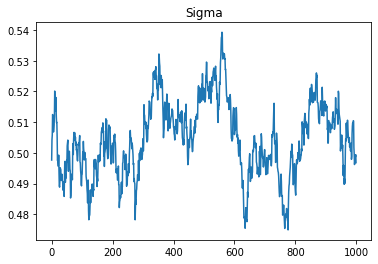

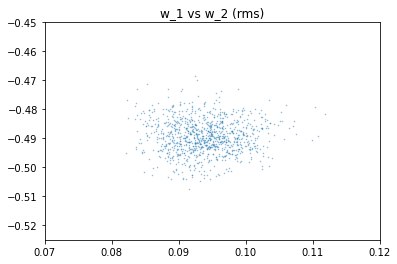

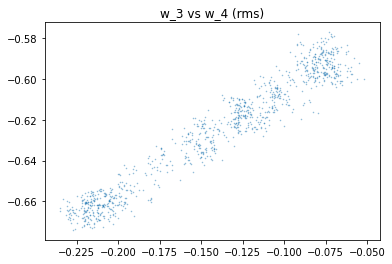

In [59]:
plt.figure()
plt.title("Sigma")

plt.plot(onp.exp(results["samples"]["variables"]["log_sigma"]), label="RMSprop")

w_rms = results["samples"]["variables"]["w"]

# w1 vs w2
w1d = onp.linspace(0.00, 0.20, 100)
w2d = onp.linspace(-0.70, -0.30, 100)
W1d, W2d = onp.meshgrid(w1d, w2d)
p12d = onp.vstack([W1d.ravel(), W2d.ravel()])

plt.figure()
plt.title("w_1 vs w_2 (rms)")

plt.xlim([0.07, 0.12])
plt.ylim([-0.525, -0.450])
plt.plot(w_rms[:, 0], w_rms[:, 1], 'o', alpha=0.5, markersize=0.5, zorder=-1)

# w3 vs w4
w3d = onp.linspace(-0.3, -0.05, 100)
w4d = onp.linspace(-0.75, -0.575, 100)
W3d, W4d = onp.meshgrid(w3d, w4d)
p34d = onp.vstack([W3d.ravel(), W4d.ravel()])

plt.figure()
plt.title("w_3 vs w_4 (rms)")
plt.plot(w_rms[:, 2], w_rms[:, 3], 'o', alpha=0.5, markersize=0.5, zorder=-1)